In [53]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import timm

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from pyts.image import GramianAngularField, MarkovTransitionField
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [54]:
X_train_normalized = np.load('E:/thesis project/thesis_proj/X_train_normalized.npy')
X_test_normalized = np.load('E:/thesis project/thesis_proj/X_test_normalized.npy')
X_train_normalized = np.load('E:/thesis project/thesis_proj/X_train_normalized.npy')
X_train_normalized_aug = np.load('E:/thesis project/thesis_proj/X_train_normalized_aug.npy')
y1_test = np.load('E:/thesis project/thesis_proj/y1_test.npy')
y1_train = np.load('E:/thesis project/thesis_proj/y1_train.npy')
y_train_int_aug = np.load('E:/thesis project/thesis_proj/y_train_int_aug.npy')
# For model
EPOCH = 30
BATCHSIZE = 32
VAL = 0.2
BASE = 'E:/thesis project/thesis_proj/'

In [55]:
benign = ['AESCrypt', 'Zip', 'SDelete', 'Excel', 'Firefox']
ransomware = ['TeslaCrypt', 'Cerber', 'WannaCry', 'GandCrab4', 'Ryuk', 'Sodinokibi', 'Darkside']

## Label Encoder

In [56]:
benign = ['AESCrypt', 'Zip', 'SDelete', 'Excel', 'Firefox']
ransomware = ['TeslaCrypt', 'Cerber', 'WannaCry', 'GandCrab4', 'Ryuk', 'Sodinokibi', 'Darkside']

In [57]:
y_train = []

for y in y1_train:
    if y in benign:
        y_train.append('Benign')
    else:
        y_train.append('Ransomware')

In [58]:
y_test = []

for y in y1_test:
    if y in benign:
        y_test.append('Benign')
    else:
        y_test.append('Ransomware')

In [59]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [60]:
lbl = LabelEncoder()

In [61]:
classes, count = np.unique(y_train, return_counts=True)
print(classes)
print(count)

['Benign' 'Ransomware']
[160 672]


In [62]:
print(lbl.fit_transform(classes), classes)
y_train_int = lbl.fit_transform(y_train)
y_train_int.shape

[0 1] ['Benign' 'Ransomware']


(832,)

In [63]:
classes_test, count_test = np.unique(y_test, return_counts=True)
print(classes_test)
print(count_test)

['Benign' 'Ransomware']
[ 41 171]


In [64]:
y_test_int = lbl.transform(y_test)
y_test_int.shape

(212,)

In [65]:
SEED = 42

## Time series as Input

In [66]:
np.random.seed(SEED)
perm = np.random.permutation(X_train_normalized.shape[0])
print(perm.shape)
perm_aug = np.random.permutation(X_train_normalized_aug.shape[0])
perm_test = np.random.permutation(X_test_normalized.shape[0])

(832,)


In [67]:
X_train_normalized = X_train_normalized[perm]
y_train_int = y_train_int[perm]

In [68]:
X_train_normalized_aug = X_train_normalized_aug[perm_aug]
y_train_int_aug = y_train_int_aug[perm_aug]

In [69]:
X_test_normalized = X_test_normalized[perm_test]
y_test_int = y_test_int[perm_test]

In [70]:
NUMCLASS = len(classes)

## LSTM

In [71]:
tf.random.set_seed(SEED)
lstm = Sequential(name='LSTM')
lstm.add(LSTM(16, activation='tanh', input_shape=(X_train_normalized.shape[1], X_train_normalized.shape[2])))
lstm.add(Dense(NUMCLASS, activation='softmax'))

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [72]:
lstm.summary()

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 16)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,442 (5.63 KB)

 Trainable params: 1,442 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
tf.random.set_seed(SEED)
lstm_history = lstm.fit(X_train_normalized, to_categorical(y_train_int), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6360 - loss: 0.6902 - val_accuracy: 0.8084 - val_loss: 0.6593
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.6417 - val_accuracy: 0.8024 - val_loss: 0.5909
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.5503 - val_accuracy: 0.8024 - val_loss: 0.5032
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.4733 - val_accuracy: 0.8024 - val_loss: 0.4974
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.4659 - val_accuracy: 0.8024 - val_loss: 0.4923
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.4622 - val_accuracy: 0.8024 - val_loss: 0.4846
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.4535 - val_accuracy: 0.8144 - val_loss: 0.4772
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8402 - loss: 0.4468 - val_accuracy: 0.8263 - val_loss

In [74]:
lstm.save(f'{BASE}/Models/lstm.h5')

## SMOTE LSTM

In [75]:
tf.random.set_seed(SEED)
lstm_aug = Sequential(name='LSTM_aug')
lstm_aug.add(LSTM(16, activation='tanh', input_shape=(X_train_normalized_aug.shape[1], X_train_normalized_aug.shape[2])))
lstm_aug.add(Dense(NUMCLASS, activation='softmax'))

lstm_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
lstm_aug.summary()

Model: "LSTM_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 16)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,442 (5.63 KB)

 Trainable params: 1,442 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
tf.random.set_seed(SEED)
lstm_aug_history = lstm_aug.fit(X_train_normalized_aug, to_categorical(y_train_int_aug), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5282 - loss: 0.6903 - val_accuracy: 0.5390 - val_loss: 0.6857
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5384 - loss: 0.6833 - val_accuracy: 0.5651 - val_loss: 0.6726
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5767 - loss: 0.6664 - val_accuracy: 0.6059 - val_loss: 0.6293
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6186 - loss: 0.6234 - val_accuracy: 0.7138 - val_loss: 0.5641
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6736 - loss: 0.5833 - val_accuracy: 0.6989 - val_loss: 0.5354
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6724 - loss: 0.5816 - val_accuracy: 0.7026 - val_loss: 0.5237
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6759 - loss: 0.5622 - val_accuracy: 0.7100 - val_loss: 0.5122
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6676 - loss: 0.5545 - val_accuracy: 0.7138 - val_loss:

In [78]:
lstm_aug.save(f'{BASE}/Models/lstm_aug.h5')

# Evaluation

## LSTM

In [79]:
tf.random.set_seed(SEED)
lstm_pred = lstm.predict(X_test_normalized)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [80]:
lstm_pred_int = np.argmax(lstm_pred, axis=1)

In [81]:
print('Accuracy:', accuracy_score(y_test_int, lstm_pred_int))
print('Precision:', precision_score(y_test_int, lstm_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, lstm_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, lstm_pred_int, average='macro'))

Accuracy: 0.8962264150943396
Precision: 0.9212166542009474
Recall: 0.740978462416203
F1-Score: 0.7921939048297986


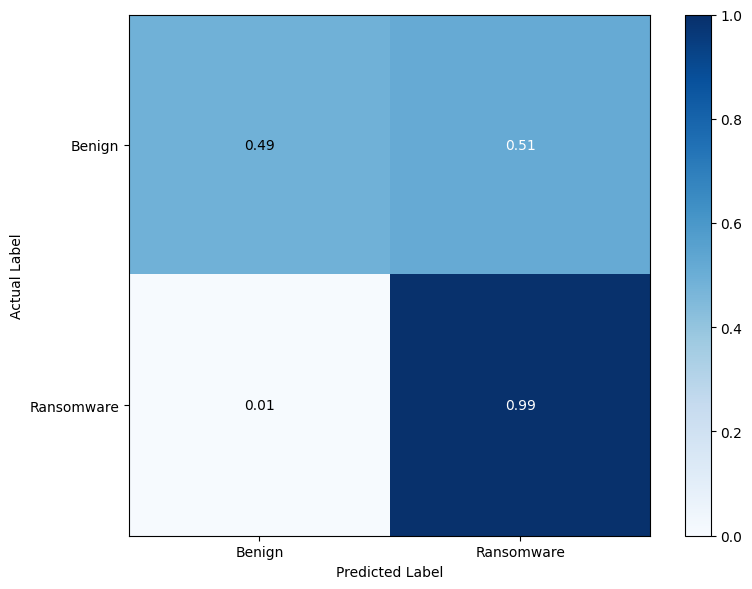

In [82]:
confusionMatrix_lstm = confusion_matrix(y_test_int, lstm_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_lstm, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_lstm.shape[0]):
    for j in range(confusionMatrix_lstm.shape[1]):
        plt.text(j, i, format(confusionMatrix_lstm[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_lstm[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

## LSTM with SMOTE

In [83]:
tf.random.set_seed(SEED)
lstm_aug_pred = lstm_aug.predict(X_test_normalized)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [84]:
lstm_aug_pred_int = np.argmax(lstm_aug_pred, axis=1)

In [85]:
print('Accuracy:', accuracy_score(y_test_int, lstm_aug_pred_int))
print('Precision:', precision_score(y_test_int, lstm_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, lstm_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, lstm_aug_pred_int, average='macro'))

Accuracy: 0.910377358490566
Precision: 0.8544817927170868
Recall: 0.861004136357153
F1-Score: 0.857682931138042


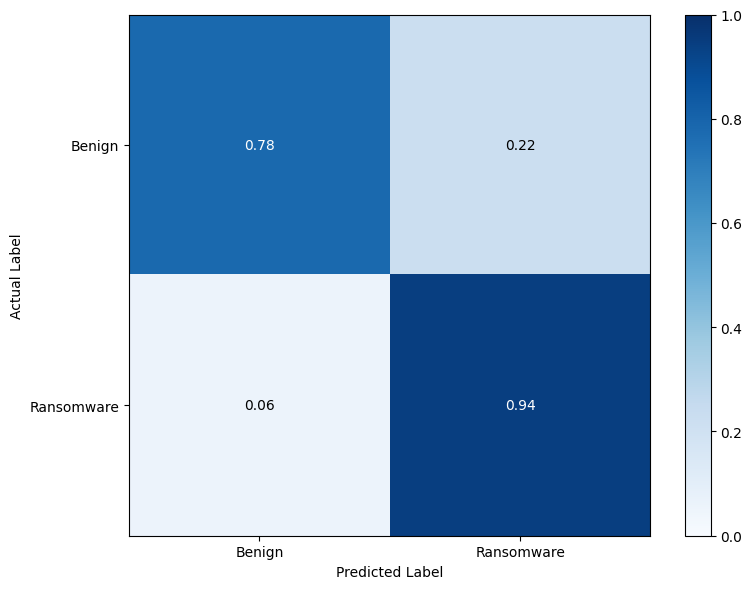

In [86]:
confusionMatrix_lstm_aug = confusion_matrix(y_test_int, lstm_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_lstm_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_lstm_aug.shape[0]):
    for j in range(confusionMatrix_lstm_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_lstm_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_lstm_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()